
# **2 Training**

Scientific Computing Infrastructure


## 1. Preparations
### 1.1 Import required packages

In [32]:
# !pip install numpy
# !pip install pandas
# !pip install scikit-learn
# !pip install matplotlib
# !pip install torch
# !pip install torchvision
# !pip install importlib
# !pip install seaborn

In [18]:
import json
import os
import zipfile
import numpy as np
import geopandas as gpd
import sklearn
import torch
import matplotlib.pyplot as plt
import torchvision
import importlib
import pickle

In [19]:
print(f"PyTorch version: {torch.__version__}\nTorchvision version: {torchvision.__version__}")

from torch import nn

PyTorch version: 2.5.1+cu124
Torchvision version: 0.20.1+cu124


### 1.2 Install segmentation model library

In [41]:
# !pip install segmentation-models-pytorch

In [23]:
import segmentation_models_pytorch as smp

/home/sc.uni-leipzig.de/rf37uqip/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1.3 Set device agnostic code

In [24]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)
print("Number of GPUs:", torch.cuda.device_count())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU identified")

CUDA available: True
CUDA Version: 12.4
Number of GPUs: 1
GPU Name: Tesla V100-PCIE-32GB


In [25]:
# use gpu if available
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 1.4 Import data directories and configs-file

In [26]:
import os
print(os.path.abspath("configs"))

/home/sc.uni-leipzig.de/rf37uqip/MoSE/notebooks/configs


In [27]:
# path to repository folder
import sys
sys.path.append(os.path.abspath('/home/sc.uni-leipzig.de/rf37uqip/MoSE/'))

In [28]:
# import configs.py-file
from configs import configs_sc
importlib.reload(configs_sc) # reload changes

<module 'configs.configs_sc' from '/home/sc.uni-leipzig.de/rf37uqip/MoSE/configs/configs_sc.py'>

In [29]:
# input directories: patches and masks
patches_dir = configs_sc.DATA_DIR["patches"]
masks_dir = configs_sc.DATA_DIR["masks"]

# output directories: trained models
models_dir = configs_sc.DATA_DIR["models"]

# additional directories: class (labels and) codes
# labels_dir = configs_sc.DATA_DIR["labels"]
codes_dir = configs_sc.DATA_DIR["codes"]

### 1.5 Import and reload scripts

In [50]:
# import data_utils.py helper-functions script
from scripts import data_utils
importlib.reload(data_utils) # reload changes

# import model_utils.py helper-functions script
from scripts import model_utils
importlib.reload(model_utils) # reload changes

# import train_utils.py helper-functions script
from scripts import train_utils
importlib.reload(train_utils) # reload changes

# import evaluation_utils.py helper-functions script
from scripts import evaluation_utils
importlib.reload(evaluation_utils) # reload changes

# import visualization_utils.py helper function script
from scripts import visualization_utils
importlib.reload(visualization_utils) # reload changes

<module 'scripts.visualization_utils' from '/home/sc.uni-leipzig.de/rf37uqip/MoSE/scripts/visualization_utils.py'>

### 1.6 Check the data

a. Class codes dict

In [34]:
codes_path = os.path.join(codes_dir, "label_codes_ohe.json") # path

# open and load the JSON file
with open(codes_path, "r") as json_file:
    codes = json.load(json_file)

# reversed dictionary
reversed_codes = {v: k for k, v in codes.items()} # v = value, k = key
reversed_codes = {k: reversed_codes[k] for k in sorted(reversed_codes)} # sort by keys
print(reversed_codes)

{0: 'background', 1: 'woody debris', 2: 'rootstock', 3: 'sand/mud bar', 4: 'gravel bar'}


b. Preprocessed patches

In [35]:
# list of all .npy-files (preprocessed patches)
################################################################################
patches_list = [f for f in os.listdir(patches_dir) if f.endswith('.npy')]
# patches_list[0:3]
len(patches_list)

2740

Shape of the patches: (3, 512, 512)
Datatype: float64
Type: <class 'numpy.ndarray'>
Mean: 0.17565934532858182
Minimum value: -2.1179039301310043
Maximum value: 2.6225708061002178
A06_patch_200.npy


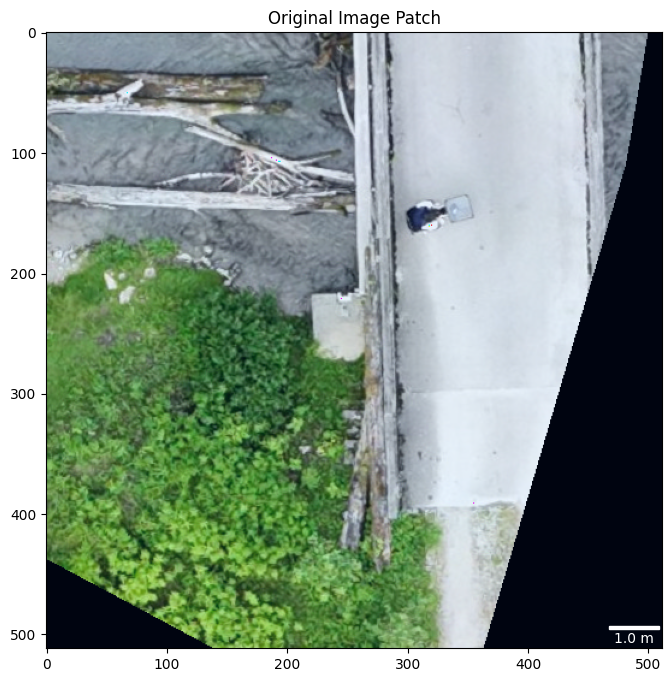

In [36]:
# Test one preprocessed patch
################################################################################

##################### choose single patch by section and id
SECTION = "A06" # -------------------->> ADJUSTABLE
TEST_PATCH_ID = 200 # -------------------->> ADJUSTABLE
#####################

# load the path to the patch
test_patch_name = f"{SECTION}_patch_{TEST_PATCH_ID}.npy"
test_patch_path = patches_dir + f"/" + test_patch_name

# load npz-file
test_patch = np.load(test_patch_path)

# Show characteristics of the patch
print("Shape of the patches:", test_patch.shape)
print("Datatype:", test_patch.dtype)
print("Type:", type(test_patch))
print("Mean:", np.mean(test_patch))
print("Minimum value:", np.min(test_patch))
print("Maximum value:", np.max(test_patch))

# import the norm_plot_patch function for normalization and plotting of the test patch
visualization_utils.norm_plot_patch(test_patch, test_patch_name)

c. Masks

In [37]:
# list of all masks
################################################################################

masks_list = [f for f in os.listdir(masks_dir) if f.endswith('_mask.npy')]  # list of all masks
# print(masks_list[0:3])
len(masks_list)

3836

In [38]:
# Test mask
################################################################################

##################### Choose single mask by section and id
SECTION = "A06" # -------------------->> ADJUSTABLE
TEST_MASK_ID = 200 # -------------------->> ADJUSTABLE
#####################

# Path to the chosen mask
test_mask_name = f"{SECTION}_patch_{TEST_MASK_ID}_mask.npy"
test_mask_path = masks_dir + f"/" + test_mask_name

# Load mask
test_mask = np.load(test_mask_path)

# Show properties of the mask
print("Shape of the mask:", test_mask.shape)
print("Datatype:", test_mask.dtype)
print("Type:", type(test_mask))
print("Minimum value:", np.min(test_mask))
print("Maximum value:", np.max(test_mask))
print("Unique values:", np.unique(test_mask), "\n") # binary mask



Shape of the mask: (5, 512, 512)
Datatype: uint8
Type: <class 'numpy.ndarray'>
Minimum value: 0
Maximum value: 1
Unique values: [0 1] 



Plot the mask

A06_patch_200_mask.npy


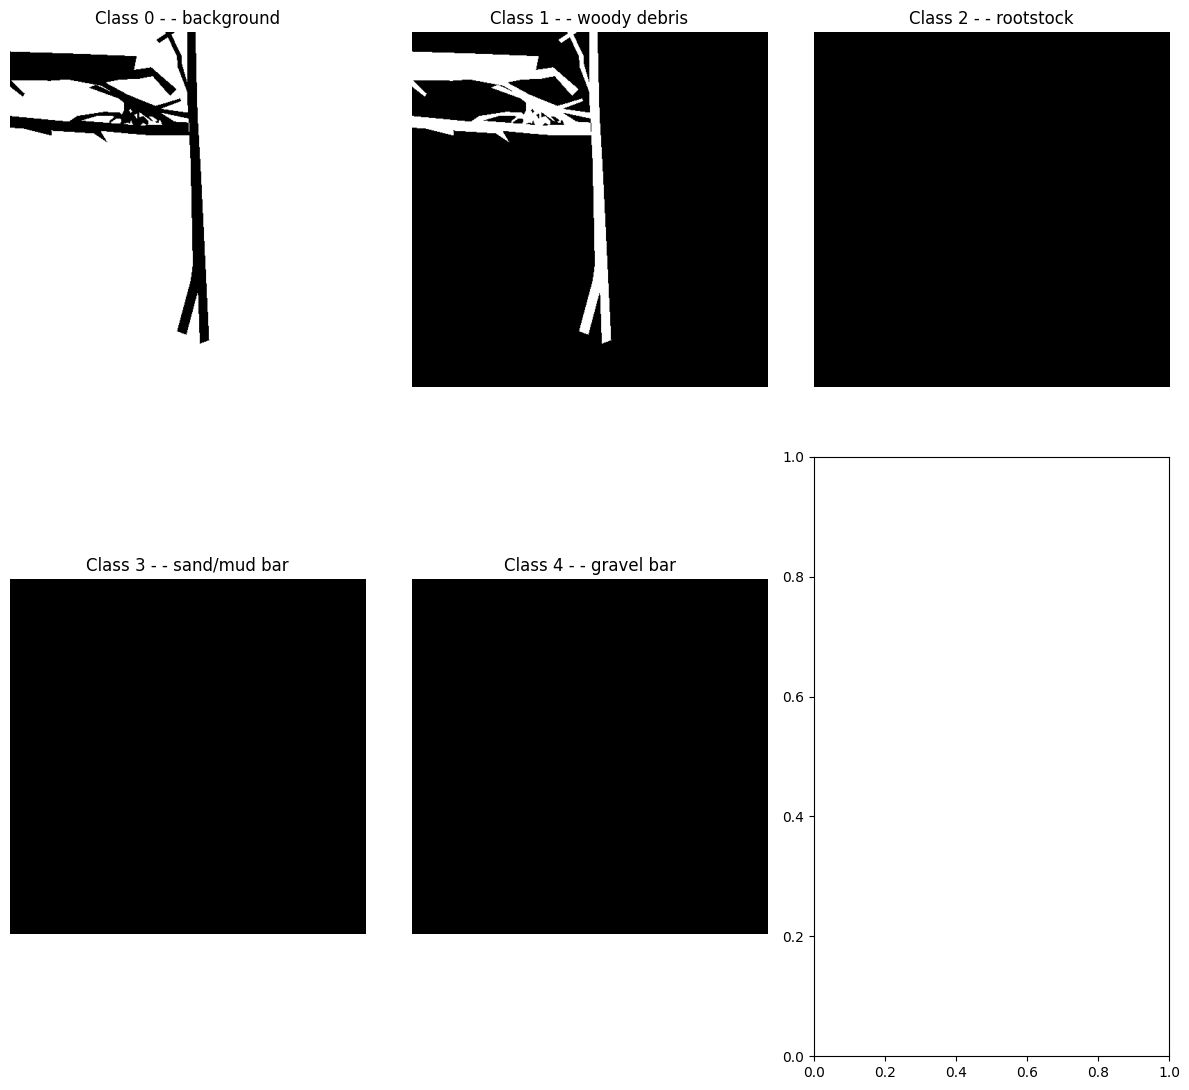

In [39]:
# ONE-HOT-ENCODED
print(test_mask_name)
fig, axes = plt.subplots(2, 3, figsize=(12, 12))  # 2x3 grid (for 5 classes)
axes = axes.flatten()  # easier to iterate through

for i in range(test_mask.shape[0]):  # iterate through the classes
  axes[i].imshow(test_mask[i], cmap="gray")
  axes[i].set_title(f"Class {i} - - {reversed_codes[i]}")
  axes[i].axis("off")

plt.tight_layout()
plt.show()

A06_patch_200_mask.npy


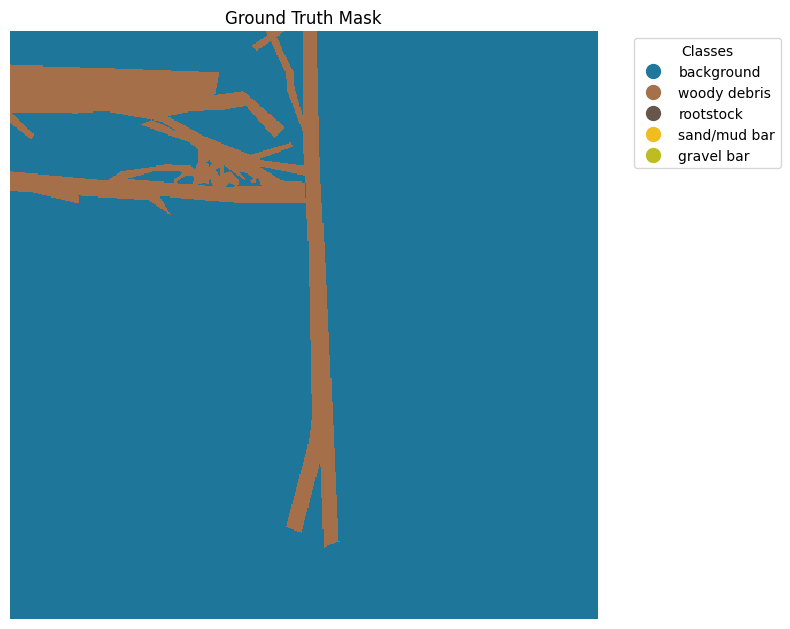

In [40]:
# alternative way of plotting the masks - not in one-hot-encoded, but in class-index-format
# CLASS-INDEX-FORMAT

# convert into class-index format
test_mask_idxformat = np.argmax(test_mask, axis=0)

visualization_utils.plot_mask_idxformat(test_mask_idxformat, test_mask_name, reversed_codes, configs_sc.HYPERPARAMETERS["custom_colors"])

Plot original image and ground truth mask together

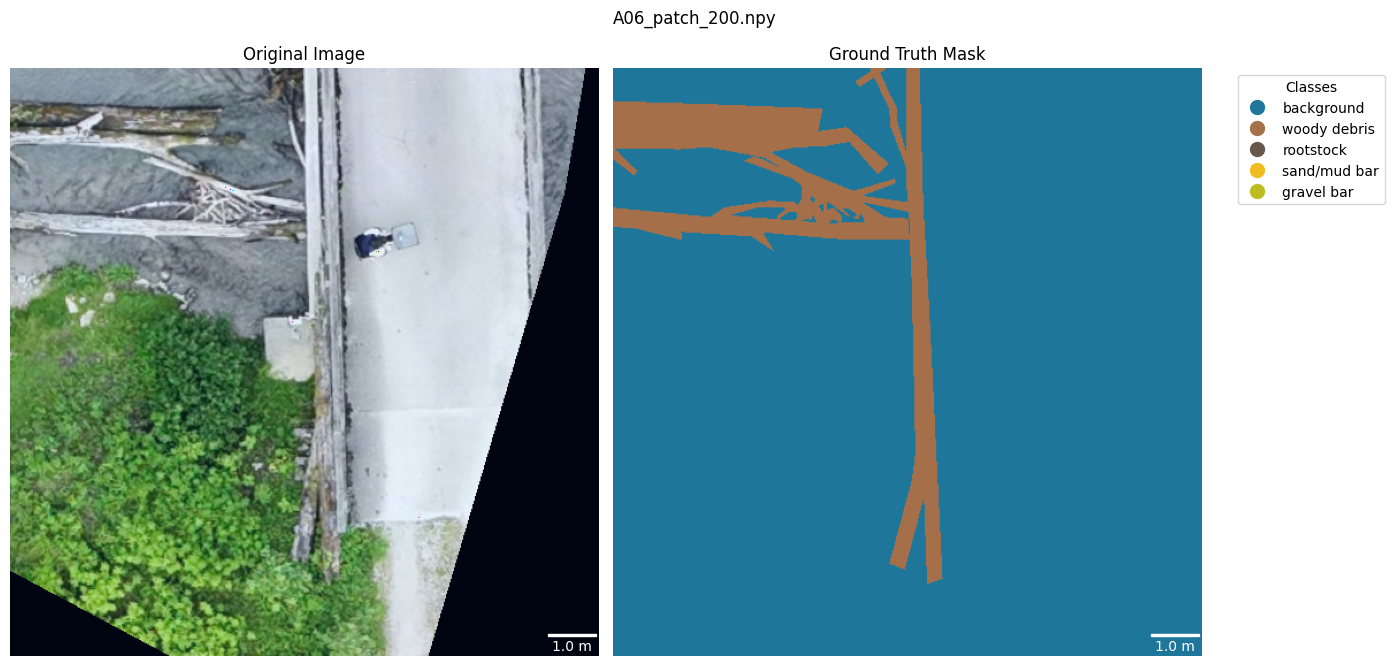

In [51]:
# import the visualize_image_and_mask function
visualization_utils.visualize_image_and_mask(
    patch = test_patch,
    mask_idxformat = test_mask_idxformat,
    patch_name = test_patch_name,
    reversed_codes = reversed_codes,
    custom_colors = configs_sc.HYPERPARAMETERS["custom_colors"]
)

## 2. Splitting data into train and test datasets

In [19]:
# extract section and patch_id from masks and patches (utils function)
# print(data_utils.extract_section_and_id(masks_list[2]))
# print(data_utils.extract_section_and_id(patches_list[175]))

In [20]:
# group patches by section
################################################################################

section_patches = {} # empty dictionary
for patch in patches_list: # iterate over all preprocessed patches
    section, patch_id = data_utils.extract_section_and_id(patch) # extract section and id
    section_patches.setdefault(section, []).append((patch)) # creates keys of sections with their patches inside

print(section_patches.keys())
# print(section_patches)

dict_keys(['A01', 'A02', 'A04', 'A06', 'A03', 'A05', 'A07', 'A08'])


In [21]:
# Separate patches in Training and Validation/Test datasets by sections
################################################################################

# empty lists for patches
train_data = []
test_data = []

for section, files in section_patches.items(): # iterates through the dictionary of sections
    if section in configs_sc.HYPERPARAMETERS["train_sections"]: # if the section is a training section
        train_data.extend(files) # if yes, the patches are added to the training data
    elif section in configs_sc.HYPERPARAMETERS["test_sections"]:
        test_data.extend(files)

print(f"Training Patches: {len(train_data)}")
print(f"Test Patches: {len(test_data)}")
print(f"Testdata-Ratio: {100*(len(test_data)/len(train_data))}")
print(f"Traindata-Ratio: {100 - 100*(len(test_data)/len(train_data))}")

Training Patches: 3077
Test Patches: 759
Testdata-Ratio: 24.666883327916803
Traindata-Ratio: 75.3331166720832


In [22]:
# # Show random patch name in training data
# print(train_data[8])

# # test if this random patch has a corresponding mask
# data_utils.has_mask(train_data[8], masks_dir)

In [23]:
# Separate training and test patches 
################################################################################

train_data = [f for f in train_data if data_utils.has_mask(f, masks_dir)]
test_data = [f for f in test_data if data_utils.has_mask(f, masks_dir)]

print(f"Training data- Number of patches: {len(train_data)}")
print(f"Test data - Number of patches: {len(test_data)}")

Training data- Number of patches: 3077
Test data - Number of patches: 759


## 3. Data augmentation, Dataset and DataLoader

### 3.1 Data augmentation

In [24]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define training transformations with augmentation using Albumentations
train_transforms = A.Compose([
    
    # horizontal flip with a probability of 0.5
    A.HorizontalFlip(p=0.5),
    # vertical flip 
    A.VerticalFlip(p=0.5), 
    
    # randomly rotate the image by 90 degrees 
    A.RandomRotate90(p=0.5), 
    
    # random adjustments to brightness, contrast, saturation, and hue
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5), 
    
    # affine transformation:
    A.Affine(rotate=(-90, 90), translate_percent=(-0.1, 0.1), scale=(0.9, 1.1), p=0.5),
    # - rotate: randomly rotate within the range (-90, 90) degrees
    # - translate_percent: randomly translate by up to ±10% of image dimensions
    # - scale: randomly scale the image between 0.9 and 1.1 times its original size
    
    # normalize the image using ImageNet statistics
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
    # covert to Tensors
    ToTensorV2() 
    
], additional_targets={'mask': 'mask'}) # ensures the same transformation is applied to the mask


# Define test transformations without augmentation (only normalization and conversion to tensor)
test_transforms = A.Compose([
    
    # normalize the image using ImageNet statistics
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
    # covert to Tensors
    ToTensorV2() 
    
], additional_targets={'mask': 'mask'}) # ensures the same transformation is applied to the mask

/home/sc.uni-leipzig.de/rf37uqip/.local/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


### 3.2 Dataset

In [25]:
# -------------------------------------------------------------------
# Setup datasets based on data augmentation
# -------------------------------------------------------------------
if configs_sc.HYPERPARAMETERS["data_augmentation"]:
    # Use the complex dataset with data augmentation (train_transforms and test_transforms)
    train_dataset = data_utils.PatchDatasetCplx(train_data, patches_dir, masks_dir, transform=train_transforms)
    test_dataset  = data_utils.PatchDatasetCplx(test_data, patches_dir, masks_dir, transform=test_transforms)
else:
    # Use the simple dataset without data augmentation
    train_dataset = data_utils.PatchDatasetSimple(train_data, patches_dir, masks_dir)
    test_dataset  = data_utils.PatchDatasetSimple(test_data, patches_dir, masks_dir)

# -------------------------------------------------------------------
# Print dataset properties
# -------------------------------------------------------------------
print("Train dataset:")
print("Type:", type(train_dataset))
print("Number of patches:", len(train_dataset))
# print("Random patch:", train_dataset[0][0])
print("Patch shape:", train_dataset[0][1].shape)
print("Mask shape:", train_dataset[0][2].shape, "\n")

print("Test dataset:")
print("Type:", type(test_dataset))
print("Number of patches:", len(test_dataset))
# print("Random patch:", test_dataset[0][0])
print("Patch shape:", test_dataset[0][1].shape)
print("Mask shape:", test_dataset[0][2].shape, "\n")


Train dataset:
Type: <class 'scripts.data_utils.PatchDatasetSimple'>
Number of patches: 3077
Patch shape: torch.Size([3, 512, 512])
Mask shape: torch.Size([5, 512, 512]) 

Test dataset:
Type: <class 'scripts.data_utils.PatchDatasetSimple'>
Number of patches: 759
Patch shape: torch.Size([3, 512, 512])
Mask shape: torch.Size([5, 512, 512]) 



### 3.3 DataLoader

Right now the data is in the form of Pytorch Datasets (see above). The next step is to prepare it with a [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) or simply `DataLoader`.

The `DataLoader`
- helps load data into the model.
- for training and for inference.
- **turns a large `Dataset` into a Python iterable** of smaller chunks. These smaller chunks are called **batches** or **mini-batches** and can be set by the `batch_size` parameter.

In [26]:
from torch.utils.data import DataLoader

BATCH_SIZE = configs_sc.HYPERPARAMETERS["batch_size"]

# Train DataLoader
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
print("Dataloader:", train_loader)

# Test DataLoader
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# Check dataloader
print(f"Training Batches: {len(train_loader)}", f"= up to {len(train_loader)*BATCH_SIZE} patches")
print(f"Test Batches: {len(test_loader)}", f"= up to {len(test_loader)*BATCH_SIZE} patches")

Dataloader: <torch.utils.data.dataloader.DataLoader object at 0x14e7af3ab2c0>
Training Batches: 385 = up to 3080 patches
Test Batches: 95 = up to 760 patches


### 3.4 Class distribution and weights

Pixel Distribution (%):
Class 0: 97.44%
Class 1: 1.44%
Class 2: 0.12%
Class 3: 0.21%
Class 4: 0.79%


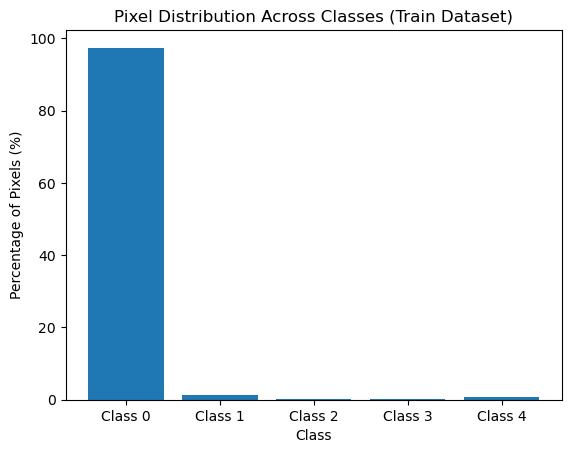

In [27]:
# TRAIN LOADER
# Show pixel distribution per class in train_loader
pixel_distribution_train = data_utils.pixel_distribution_dataloader(
    data_loader=train_loader,
    num_classes= configs_sc.HYPERPARAMETERS["num_classes"],
    device=device
)

# Visualize results
plt.bar(pixel_distribution_train.keys(), pixel_distribution_train.values())
plt.xlabel("Class")
plt.ylabel("Percentage of Pixels (%)")
plt.title("Pixel Distribution Across Classes (Train Dataset)")
plt.xticks()
plt.show()

In [28]:
pixel_dist_train = torch.tensor(list(pixel_distribution_train.values()), dtype=torch.float32, device=device)
# pixel_dist_train = torch.tensor([98.5564,  1.4437], dtype=torch.float32, device=device)
print("Pixel distribution in train dataset:", pixel_dist_train)

Pixel distribution in train dataset: tensor([97.4372,  1.4437,  0.1185,  0.2076,  0.7930])


In [29]:
# calculate the (inverse proportional) weights to outweigh the class imbalances
class_weights = 1/ (pixel_dist_train/100)
print("Class weights:", class_weights)

normalized_weights = class_weights / class_weights.sum()
print("Normalized weights:", normalized_weights)

Class weights: tensor([  1.0263,  69.2676, 844.0437, 481.5831, 126.1078])
Normalized weights: tensor([0.0007, 0.0455, 0.5546, 0.3164, 0.0829])


To take into account the class imbalances in this dataset, we adjust the weight parameters in the CrossEntropyLoss function accordingly. Based on the pixel distribution, the weights can be set as follows:

| Class | Average pixel distribution (%) | Normalized Weight |
| ----- | ----- | ----- |
| 0 | 98.5564 | 0.0144 |
| 1 | 1.4437   | 0.9856 |


(
| 2 | 0.1185 | 0.5546 |
| 3 | 0.2076 | 0.3164 |
| 4 | 0.7930 | 0.0829 |
)

## 4. Segmentation model

In [30]:
################################################################################
# model_0 = smp.Unet(   # -------------------->> ADJUSTABLE
#     encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#     encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
#     in_channels=3,                  # model input channels (3 for RGB)
#     classes=configs_sc.HYPERPARAMETERS["num_classes"],       # model output channels (number of classes)
# )
################################################################################

In [31]:
model = model_utils.model_0.to(device)

# show model costruction
# model.to(device)

# show (hidden) layers of the model
# model.state_dict().keys()

In [32]:
next(model.parameters()).device

device(type='cpu')

### 4.1 Setup loss, optimizer and evaluation metrics

Setup loss function and optimizer

In [33]:
# Setup loss function
# loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.CrossEntropyLoss(weight = normalized_weights).to(device)

In [34]:
# Setup optimizer
# optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)
# optimizer = torch.optim.Adam(model.parameters(), configs_sc.HYPERPARAMETERS["learning_rate"], betas=(0.9, 0.999))

# AdamW = Adam with weight decay
from torch.optim import AdamW

optimizer = AdamW(
    model.parameters(),
    lr=configs_sc.HYPERPARAMETERS["learning_rate"],  # learning rate
    weight_decay=1e-4  # regularisation
)

Evaluation metrics

In [35]:
accuracy_fn = evaluation_utils.oa_accuracy_fn

### 4.2 Training and test loop

1. Loop through epochs.
2. Loop through training batches, perform training steps, calculate the train loss per batch.
3. Loop through testing batches, perform testing steps, calculate the test loss per batch.

In [ ]:
from tqdm.auto import tqdm

# Fix random seed for reproducibility
torch.manual_seed(configs_sc.HYPERPARAMETERS["seed"])
torch.cuda.manual_seed(configs_sc.HYPERPARAMETERS["seed"])
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print("Learning rate:", configs_sc.HYPERPARAMETERS["learning_rate"])
print("Number of epochs:", configs_sc.HYPERPARAMETERS["epochs"])

# measure time with timing function
from timeit import default_timer as timer
start = timer()

# empty lists for storing of evaluation metrics
train_loss_progress = []
test_loss_progress = []
train_class_wise_losses = []
test_class_wise_losses = []

# epoch loop
for epoch in tqdm(range(configs_sc.HYPERPARAMETERS["epochs"])):
    print(f"Epoch: {epoch}\n---------") # print current epoch

    train_loss_epoch, train_class_wise_loss = train_utils.train_step(
        model=model,
        num_classes=configs_sc.HYPERPARAMETERS["num_classes"],
        data_loader=train_loader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )

    train_loss_progress.append({"epoch": epoch + 1, "train loss": train_loss_epoch})
    train_class_wise_losses.append(train_class_wise_loss.cpu().numpy())  # change to numpy for easier plotting

    test_loss_epoch, test_class_wise_loss = train_utils.test_step(
        model=model,
        num_classes=configs_sc.HYPERPARAMETERS["num_classes"],
        data_loader=test_loader,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

    test_loss_progress.append({"epoch": epoch + 1, "test loss": test_loss_epoch})
    test_class_wise_losses.append(test_class_wise_loss.cpu().numpy())


    # Clear output and update plot
    epochs = [entry["epoch"] for entry in train_loss_progress]
    train_losses = [entry["train loss"] for entry in train_loss_progress]
    test_losses = [entry["test loss"].cpu().item() for entry in test_loss_progress]

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label="Train Cross Entropy Loss")
    plt.plot(epochs, test_losses, label="Test Cross Entropy Loss")
    plt.xlabel("Epoch []")
    plt.ylabel("Cross Entropy Loss []")
    plt.title("Train and Test Cross Entropy Loss Over Epochs")
    plt.xlim(left=0) # Force x-axis to start at epoch 0
    plt.ylim(bottom=0) # Force y-axis to start at 0
    plt.legend()
    plt.grid(True)
    plt.show()



end = timer()
train_utils.print_train_time(start, end, device)

Learning rate: 1e-06
Number of epochs: 50


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
---------
Train Loss of [Batch 0/385]: 1.5998
Train Loss of [Batch 100/385]: 1.9594


### 4.3 Loss Curves

In [ ]:
# try_epoch = 2 # ADJUSTABLE!
# Plot train class-wise loss of a specific epoch
# visualization_utils.plot_classwise_loss(try_epoch, train_class_wise_losses, configs_sc.HYPERPARAMETERS["num_classes"])

# Plot test class-wise loss of a specific epoch
# visualization_utils.plot_classwise_loss(try_epoch, test_class_wise_losses, configs_sc.HYPERPARAMETERS["num_classes"])

In [ ]:
# Plot the train loss curves per class
visualization_utils.plot_loss_curves_per_class(train_class_wise_losses, "Train", 
                           configs_sc.HYPERPARAMETERS["num_classes"], reversed_codes,
                           configs_sc.HYPERPARAMETERS["custom_colors"])

In [ ]:
# Plot the test loss curves per class
visualization_utils.plot_loss_curves_per_class(test_class_wise_losses, "Test", 
                           configs_sc.HYPERPARAMETERS["num_classes"], reversed_codes,
                           configs_sc.HYPERPARAMETERS["custom_colors"])

## 5. Save and load trained model

### 5.1 Save model and loss values

1. Create individual name of the trained model

In [ ]:
# model version
version = 1

# function for generating initial model name
def generate_model_name(base_name, num_classes, dataaug, epochs, version):
    return f"{base_name}_{num_classes}cls_{dataaug}aug_{epochs}ep_v{version}.pth"
    
base_name = "model"
if configs_sc.HYPERPARAMETERS["data_augmentation"] == True:
    dataaug = "data"
else:
    dataaug = "NOdata"

# generate initial name and path
MODEL_NAME = generate_model_name(base_name,  configs_sc.HYPERPARAMETERS["num_classes"],  dataaug, configs_sc.HYPERPARAMETERS["epochs"], version)
save_model_path = os.path.join(models_dir, MODEL_NAME)

# check if there is already a model saved with the same name -> if so: increase the counter
while os.path.exists(save_model_path):
    print(f"Warning: File with name {MODEL_NAME} already exists. Increase the counter...")
    version += 1
    MODEL_NAME = generate_model_name(base_name,  configs_sc.HYPERPARAMETERS["num_classes"],  dataaug, configs_sc.HYPERPARAMETERS["epochs"], version)
    save_model_path = os.path.join(models_dir, MODEL_NAME)

2. Save the models state dict

In [ ]:
print(f"Saving model to: {save_model_path}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=save_model_path)

3. Save and load loss values

In [ ]:
# Create a dictionary with your metrics
loss_values = {
    "train_loss_progress": train_loss_progress,
    "test_loss_progress": test_loss_progress,
    "train_class_wise_losses": train_class_wise_losses,
    "test_class_wise_losses": test_class_wise_losses
}

# Save the loss values to a file using pickle
with open(f"{models_dir}/loss_values_{MODEL_NAME}.pkl", "wb") as f:
    pickle.dump(loss_values, f)

print(f"{models_dir}loss_values_{MODEL_NAME}.pkl")

In [ ]:
with open(f"{models_dir}/loss_values_{MODEL_NAME}.pkl", "rb") as f:
    loaded_metrics = pickle.load(f)

### 5.2 Load the model

In [ ]:
#######
MODEL_NAME = "unet_model_2class_dataaugmentation_100_50_1.pth"
#######
print("Loaded model:", MODEL_NAME)

save_model_path = os.path.join(models_dir, MODEL_NAME)

# Create a new instance of the model (same class as our saved state_dict())
loaded_model = model_utils.model_0.to(device)

# Load in the saved state_dict()
loaded_model.load_state_dict(torch.load(f=save_model_path, weights_only=True))

# Send model to GPU
loaded_model = loaded_model.to(device)

## 6. Evaluate trained model

Make predictions for the entire test data set with the trained model and display the results in a confusion matrix.

### 6.1 Confusion Matrix Metrics
Accuracy, Precision, Recall and F1-Scores

Confusion Matrix for entire test data set!

In [ ]:
# predictions for entire test data set
evaluation_utils.evaluate_model_with_testdata(loaded_model, test_loader, accuracy_fn, configs_sc.HYPERPARAMETERS["num_classes"], device, F1_analysis = True)

### 6.2 Visual Evaluation

In [ ]:
##################### Choose single patch by section and id
SECTION = "A04" # -------------------->> ADJUSTABLE
TEST_PATCH_ID = 230 # -------------------->> ADJUSTABLE
#####################

test_patch_name = f"{SECTION}_patch_{TEST_PATCH_ID}.npy"

visualization_utils.visualize_prediction(test_patch_name, test_loader, loaded_model, device, 
                                         reversed_codes, configs_sc.HYPERPARAMETERS["custom_colors"], show = True)

In [ ]:
visualization_utils.visualize_all_test_patches(test_loader, loaded_model, device, reversed_codes, 
                           configs_sc.HYPERPARAMETERS["custom_colors"], 
                           output_pdf_base = f"{models_dir}visualPDF_{MODEL_NAME}")

## Citing

In [ ]:
# @misc{Iakubovskii:2019,
#   Author = {Pavel Iakubovskii},
#   Title = {Segmentation Models Pytorch},
#   Year = {2019},
#   Publisher = {GitHub},
#   Journal = {GitHub repository},
#   Howpublished = {\url{https://github.com/qubvel/segmentation_models.pytorch}}
# }